# Road damage - Iterative annotations on road damage images

This tutorial demonstrates how you can build an annotated dataset for road damage classification without ever leaving the
jupyter notebook / lab. We do this in three steps:

1. Use bounding box annotation to crop the original images.
2. Group the road damage types in categories using classification labels.
3. Refine the inital class labels in a supervision step.

These steps can be applied iteratively for practical applications. By integrating the predictions of imperfect machine learning models, the process can be accelerated significantly.
For example we might train an image classification model on the first annotations, which then refines the prediction on new data. Therewith, the training data size is increased, then repeat the process.

**Install @jupyter-widgets/jupyter-manager. To do this, go to puzzle/jigsaw symbol and install the widget manually.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#all_slow

## Get Road Damage Images from BigData Cup 2020

First we need to retrieve some images from which we can build our dataset. The [Global Road Damage Detection Challenge 2020](https://rdd2020.sekilab.global/data/) provides images that are free to use and can be download. (Please cite [the paper](https://github.com/sekilab/RoadDamageDetector#citation) if you use this for your own work).

### Installing via `pooch`

For this tutorial, we provide a Github repository with a subset of the Global Road Damage Detection Challenge, containing only the images from Japan.

In [3]:
import pooch
import zipfile
from pathlib import Path

github_repo = pooch.create(
    path=pooch.os_cache("tutorial_road_damage"),
    base_url="https://github.com/palaimon/ipyannotator-data/raw/main/",
    registry={
        "road_damage.zip": "sha256:639b3aec3f067a79b02dd12cae4bdd7235c886988c7e733ee3554a8fc74bc069"
    }
)

road_damage_zip = github_repo.fetch("road_damage.zip")
path_zip = Path(road_damage_zip)

In [4]:
path = path_zip.parent

with zipfile.ZipFile(road_damage_zip, 'r') as zip_ref:
    zip_ref.extractall(path)

path_japan = path / "road_damage"
path_japan

PosixPath('/home/runner/.cache/tutorial_road_damage/road_damage')

## 1. Use bounding box annotation to crop the orignal imges.

We can now use the BBoxAnnotator to quickly inspect the available images.

In [5]:
from ipyannotator.bbox_annotator import BBoxAnnotator
from ipyannotator.mltypes import (
    InputImage, OutputImageBbox,
    OutputImageLabel, OutputGridBox
)
from ipyannotator.storage import construct_annotation_path

In [6]:
project_path = Path(path_japan)
in_p = InputImage(image_dir='images', image_width=500, image_height=500)
out_p = OutputImageBbox()
annotation_file_path = construct_annotation_path(
    file_name=path_japan / 'results' / 'bbox_annotator' / 'annotation.json'
)

bb = BBoxAnnotator(
    project_path=project_path,
    input_item=in_p,
    output_item=out_p,
    annotation_file_path=annotation_file_path
)

In [7]:
bb

BBoxAnnotatorGUI(children=(HBox(children=(Navi(children=(Button(description='< Previous', layout=Layout(width=…

In [8]:
from ipyannotator.mltypes import BboxCoordinate
results = list(bb.to_dict().values())
if not results or not results[0]['bbox']:
    """Annotate if not manually selected a bbox"""
    bb.app_state.index = 6
    bb.controller.save_current_annotations([
        BboxCoordinate(**{
            'x': 298,
            'y': 93,
            'width': 536,
            'height': 430
        })
    ])

Let's now create an inital set of road damage images by using the mouse to draw a reactangle containing
the damage on individual images. Below you seed the annotation for a single image.

In [9]:
img_path, bbox = list(bb.to_dict().items())[1]
print(img_path)
print(bbox)

/home/runner/.cache/tutorial_road_damage/road_damage/images/Japan_000060.jpg
{'bbox': [{'x': 298, 'y': 93, 'width': 536, 'height': 430}], 'labels': []}


We can now use the bounding box annotations to crop damages from the images and save them in a seperate folder.
The following small function helps us to accomplish this.

In [10]:
from PIL import Image
from pathlib import Path


def crop_bboxs(bbox_annotations, source_dir, target_dir):
    Path(target_dir).mkdir(parents=True, exist_ok=True)
    for img_file, items in bbox_annotations.items():
        img_file = img_file.split('/')[-1]
        # box = (left, upper, right, lower)
        if 'bbox' in items and items['bbox']:
            b = items['bbox'][0]
            box_crop = (b['x'], b['y'], b['x'] + b['width'], b['y'] + b['height'])
            Image.open(Path(source_dir) / img_file).crop(box_crop).save(
                Path(target_dir) / img_file, quality=95)

In [11]:
to_crop = {k: v for k, v in bb.to_dict().items() if v['bbox']}
crop_bboxs(bbox_annotations=to_crop, source_dir=path_japan / 'images',
           target_dir=path_japan / 'images_croped')

Below you can see the croping result from the bbox annotation above.

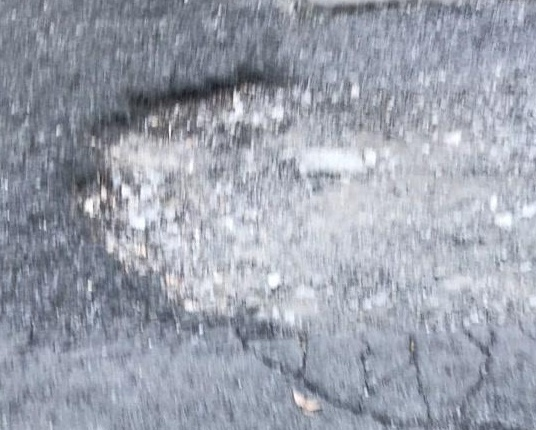

In [12]:
Image.open(Path(path_japan / 'images_croped') / img_path.split('/')[-1])

We first need to decide on the type of damages we want to classify. If we don't know this upfront we can initially create some
dummy labels.

In [13]:
# create dummy label_images
crop_bboxs(bbox_annotations={k: v for k, v in list(bb.to_dict().items())[:4]},
           source_dir=path_japan / 'images', target_dir=path_japan / 'class_images')

## 2. Group the road damage types in categories using classification labels.

1. We can now use the `Im2ImAnnotator` to quickly explore the cropped images in order to find some typical damage types we are interested in. 
  * The competition list the following types {D00: Longitudinal Crack, D10: Transverse Crack, D20: Aligator Crack, D40: Pothole}.
  * Hint: Check out https://en.wikipedia.org/wiki/Pavement_cracking to find some typical crack types.
2. Select a representative example for each damage type you are interested in and move the file to `road_japan/class_images`.
  * remove the existing dummy images first
  * give the image a nice name illustrative name such as aligator_crack.jpg. The file name is used to create the class labels.
3. Label the images by selecting one or more labels on the right side below "Damage Types".

In [14]:
from ipyannotator.im2im_annotator import Im2ImAnnotator

In [15]:
in_p = InputImage(image_dir='images', image_width=600, image_height=500)

out_p_label = OutputImageLabel(label_dir='images_croped', label_width=100, label_height=100)

annotation_file_path = construct_annotation_path(
    file_name=path_japan / 'results' / 'im2im_annotator' / 'annotation.json'
)

im2im = Im2ImAnnotator(
    project_path=project_path,
    input_item=in_p,
    output_item=out_p_label,
    n_cols=2,
    n_rows=3,
    question="Damage Types",
    annotation_file_path=annotation_file_path
)

im2im

Im2ImAnnotatorGUI(children=(HBox(children=(VBox(children=(ImCanvas(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR…

We can now check the class labels that we have just created and save them to a JSON file.

In [16]:
from IPython import display
display.JSON(im2im.to_dict())

<IPython.core.display.JSON object>

In [17]:
if not im2im.to_dict():
    """Annotate if not manually selected a label"""
    im2im.controller.idx_changed(6)
    im2im.im2im_state.annotations = {
        # Dict entry 0 has incompatible type "Path": "Dict[str, bool]";
        # expected "str": "Optional[List[str]]"
        path / 'images_croped' / 'Japan_000060.jpg': {'answer': True}  # type: ignore
    }
    im2im.controller.save_annotations(6)

im2im.to_dict()

{'/home/runner/.cache/tutorial_road_damage/road_damage/images/Japan_000060.jpg': ['Japan_000060.jpg']}

In [18]:
import json
with open(path_japan / 'classification_labels.json', 'w') as outfile:
    items = im2im.to_dict()

    if not items:
        items = {path_japan / 'images' / 'Japan_000060.jpg': ['Japan_000060.jpg']}

    json.dump(im2im.to_dict(), outfile)
im2im.to_dict()

{'/home/runner/.cache/tutorial_road_damage/road_damage/images/Japan_000060.jpg': ['Japan_000060.jpg']}

## 3. Refine the inital class labels in a supervision step.

After initial data labeling, supervision is a great way to further improve the data quality by reviewing annotations generated by hand or a
machine learning model.

In [19]:
# text example data
# image_annotations = {'Japan_000342.jpg': ['Japan_010778.jpg'],
#  'Japan_000541.jpg': ['Japan_011190.jpg'],
#  'Japan_001155.jpg': ['Japan_003206.jpg', 'Japan_010778.jpg'],
#  'Japan_002337.jpg': ['Japan_001155.jpg'],
#  'Japan_003206.jpg': ['Japan_011190.jpg'],
#  'Japan_005979.jpg': ['Japan_010778.jpg'],
#  'Japan_006775.jpg': ['Japan_003206.jpg'],
#  'Japan_007389.jpg': ['Japan_003206.jpg'],
#  'Japan_010778.jpg': ['Japan_003206.jpg', 'Japan_010778.jpg'],
#  'Japan_011190.jpg': ['Japan_001155.jpg', 'Japan_010778.jpg'],
#  'Japan_012213.jpg': ['Japan_011190.jpg']}

We can now use the priviously generated class labels to group the images by class.

In [20]:
with open(path_japan / 'classification_labels.json') as infile:
    image_annotations = json.load(infile)

In [21]:
from collections import defaultdict


def group_files_by_class(annotations):
    grouped = defaultdict(list)
    for file, labels in annotations.items():
        for class_ in labels:
            grouped[class_].append(file)
    return grouped

We have the following classes.

In [22]:
classes_to_files = group_files_by_class(image_annotations)
classes_to_files.keys()

dict_keys(['Japan_000060.jpg'])

In [23]:
classes_to_files

defaultdict(list,
            {'Japan_000060.jpg': ['/home/runner/.cache/tutorial_road_damage/road_damage/images/Japan_000060.jpg']})

We can pick any class to start the supervision, we just take the first one here.

In [24]:
selected_class = list(classes_to_files.keys())[0]
selected_class

'Japan_000060.jpg'

In [25]:
from ipyannotator.capture_annotator import CaptureAnnotator

In [26]:
html_question = ('Select images that don\'t belong to class'
                 '<span style="color:red;">{}</span>').format(selected_class)

The annotator now shows us a grid of images annotated as belonging to the same class. You can now quickly click through
this batches and select the images that belong to a different class.

In [27]:
in_p = InputImage(image_dir='images', image_width=150, image_height=150)

out_p_grid = OutputGridBox()

annotation_file_path = construct_annotation_path(
    file_name=path_japan / 'results' / 'capture_annotator' / 'annotation.json'
)

ca = CaptureAnnotator(
    project_path=project_path,
    input_item=in_p,
    output_item=out_p_grid,
    n_cols=2,
    n_rows=2,
    question=html_question,
    filter_files=classes_to_files[selected_class],
    annotation_file_path=annotation_file_path
)

ca

CaptureAnnotatorGUI(children=(HBox(children=(Navi(children=(Button(description='< Previous', layout=Layout(wid…

You can repeat this process for each class and then reclassify the images with wrong labels in a later step. The Capture annotator is very useful when you already have a dataset with imperfect image classifications which could stem from a pretrained model. It is also very usefull if the dataset was annotated by many less experienced annotators which needs to be checked/improved by few experts. 

In [28]:
ca.to_dict()

{}

## Conclusion

This short tutorial has demonstrated how annotation UI's, that are already included in Ipyannotator, can be used to quickly annotate images.
Clearly this case is a very simple example and the real power of using the Ipyannotator concept lays in building project specific UI's.
Check out the other notebooks to get inspired how this can be done.